Importing the dataset and making the train test validation splits for the voronoi images

In [ ]:
import os
import glob
import random
import torch
from torch_geometric.data import Data, Dataset
from torch.utils.data import random_split
import shutil  # For copying files

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set relative paths to dataset
graphs_dir = "graphs"  # Path to the folder containing the graph files

# Root dataset directory (must contain only graph files)
root_dir = "binary_dataset"
binary = os.path.join(root_dir, "binary")
immunogenic_dir = os.path.join(binary, "immunogenic")
non_immunogenic_dir = os.path.join(binary, "non_immunogenic")

# Separate directories for saving dataset splits
graph_data_dir = os.path.join(root_dir, "graph_datasets")

# Ensure directories for the dataset splits exist
os.makedirs(immunogenic_dir, exist_ok=True)
os.makedirs(non_immunogenic_dir, exist_ok=True)

# Ensure dataset folders exist for saving train/val/test splits
os.makedirs(graph_data_dir, exist_ok=True)

# Copy graph files into class-labeled folders **only if they are not already copied**
if not os.listdir(immunogenic_dir) or not os.listdir(non_immunogenic_dir):
    print("Copying graph files into class-labeled folders...")
    for src_dir, dst_dir in [(graphs_dir, immunogenic_dir), (graphs_dir, non_immunogenic_dir)]:
        for graph_path in glob.glob(os.path.join(src_dir, "*.pt")):  # Assuming graph files are in .pt format
            shutil.copy(graph_path, os.path.join(dst_dir, os.path.basename(graph_path)))  # Copy instead of move
    print("Graph dataset successfully copied and organized.")
else:
    print("Dataset already organized. Skipping file copy.")

# Ensure dataset folders are not empty before proceeding
if not os.listdir(immunogenic_dir) or not os.listdir(non_immunogenic_dir):
    raise FileNotFoundError("Error: Immunogenic or non-immunogenic directories are empty.")

# Define dataset paths for splits
train_set_path = os.path.join(graph_data_dir, "train_set.pth")
val_set_path = os.path.join(graph_data_dir, "val_set.pth")
test_set_path = os.path.join(graph_data_dir, "test_set.pth")

# Check if the dataset splits already exist before processing
if not (os.path.exists(train_set_path) and os.path.exists(val_set_path) and os.path.exists(test_set_path)):
    print("Processing graph dataset...")

    # Create a custom Dataset class for graphs
    class GraphDataset(Dataset):
        def __init__(self, graph_dir):
            self.graph_paths = glob.glob(os.path.join(graph_dir, "*.pt"))  # Assuming graph files are in .pt format
            self.graph_paths.sort()  # Sort for consistency in splitting

        def len(self):
            return len(self.graph_paths)

        def get(self, idx):
            graph_path = self.graph_paths[idx]
            graph_data = torch.load(graph_path)  # Load graph (adjust based on your file format)
            return graph_data

    # Initialize dataset
    dataset = GraphDataset(binary)

    # Split dataset into train (75%), validation (5%), and test (20%)
    train_size = int(0.75 * len(dataset))
    val_size = int(0.05 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Save dataset splits
    torch.save(train_set, train_set_path)
    torch.save(val_set, val_set_path)
    torch.save(test_set, test_set_path)
    print(f"Graph dataset saved in {graph_data_dir}. Train: {train_size}, Val: {val_size}, Test: {test_size}")
else:
    print("Graph dataset already processed. Skipping dataset split.")

# Load the processed graph datasets
train_set = torch.load(train_set_path)
val_set = torch.load(val_set_path)
test_set = torch.load(test_set_path)

print(f"Dataset saved. Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Dataset already organized. Skipping file copy.
Image dataset already processed. Skipping dataset split.
Dataset saved Train: 779, Val: 51, Test: 209


Importing the dataset and making the train test validation splits for the graphs

In [ ]:
import os
import torch
import random
import torch_geometric
from torch_geometric.data import Data

# Allow PyTorch Geometric data types for safe unpickling
torch.serialization.add_safe_globals([
    torch_geometric.data.Data,  # Standard PyG data class
    torch_geometric.data.Batch,  # If you're using batch processing
])

# Set seed for reproducibility
random.seed(42)

# Define paths
base_dir = os.getcwd()  # Assumes script is in the same directory
immunogenic_path = os.path.join(base_dir, "tumor_antigens_immunogenic", "graphs")
non_immunogenic_path = os.path.join(base_dir, "tumor_antigens_non-immunogenic", "graphs")

# Destination folder for the output datasets
output_dir = os.path.join(base_dir, "binary_dataset", "graph_datasets")
os.makedirs(output_dir, exist_ok=True)  # Create directories if they don't exist

# Load file paths
immunogenic_files = [(os.path.join(immunogenic_path, f), 1) for f in os.listdir(immunogenic_path) if f.endswith(".pth")]
non_immunogenic_files = [(os.path.join(non_immunogenic_path, f), 0) for f in os.listdir(non_immunogenic_path) if f.endswith(".pth")]

# Combine and shuffle data
data = immunogenic_files + non_immunogenic_files
random.shuffle(data)

# Split sizes
total = len(data)
train_size = int(0.75 * total)
val_size = int(0.05 * total)
test_size = total - train_size - val_size  # Ensures the sum is total

# Split datasets
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Function to save dataset with labels inside the PyG Data object and count labels
def save_dataset(data, filename):
    dataset = []
    label_counts = {0: 0, 1: 0}  # Counters for label distribution

    for file_path, label in data:
        graph_data = torch.load(file_path, weights_only=False)  # Load PyG Data object
        graph_data.y = torch.tensor([label], dtype=torch.float)  # Attach label inside graph_data
        dataset.append(graph_data)

        # Count labels
        label_counts[label] += 1  

    torch.save(dataset, os.path.join(output_dir, filename))

    return label_counts  # Return label distribution for this dataset

# Save datasets and count labels
train_counts = save_dataset(train_data, "train_set.pth")
val_counts = save_dataset(val_data, "val_set.pth")
test_counts = save_dataset(test_data, "test_set.pth")

# Print dataset sizes and label distribution
print(f"Training samples: {len(train_data)} (Class 0: {train_counts[0]}, Class 1: {train_counts[1]})")
print(f"Validation samples: {len(val_data)} (Class 0: {val_counts[0]}, Class 1: {val_counts[1]})")
print(f"Test samples: {len(test_data)} (Class 0: {test_counts[0]}, Class 1: {test_counts[1]})")
print(f"Datasets saved in {output_dir}")


Training samples: 786 (Class 0: 393, Class 1: 393)
Validation samples: 52 (Class 0: 28, Class 1: 24)
Test samples: 210 (Class 0: 99, Class 1: 111)
Datasets saved in /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/binary_dataset/graph_datasets


Testing the benchmark model used in the paper of ibionet where they used the ResNet18 to trained their model but with feature extraction (only the last layer is being retrained the rest of the model remains frozen and does transfer learning). This is the method they used in their paper.

Using device: mps


/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 17.8261, Train Acc: 0.5096, Val Acc: 0.5686, Val Loss: 0.6504
Epoch 2/10 - Loss: 15.9368, Train Acc: 0.6624, Val Acc: 0.7647, Val Loss: 0.5773
Epoch 3/10 - Loss: 14.7216, Train Acc: 0.7176, Val Acc: 0.7451, Val Loss: 0.5480
Epoch 4/10 - Loss: 14.0238, Train Acc: 0.7317, Val Acc: 0.7451, Val Loss: 0.5280
Epoch 5/10 - Loss: 13.6622, Train Acc: 0.7433, Val Acc: 0.7647, Val Loss: 0.5169
Epoch 6/10 - Loss: 13.2459, Train Acc: 0.7548, Val Acc: 0.7647, Val Loss: 0.4944
Epoch 7/10 - Loss: 12.9531, Train Acc: 0.7535, Val Acc: 0.7647, Val Loss: 0.4992
Epoch 8/10 - Loss: 12.7384, Train Acc: 0.7677, Val Acc: 0.7647, Val Loss: 0.4778
Epoch 9/10 - Loss: 12.6315, Train Acc: 0.7728, Val Acc: 0.7451, Val Loss: 0.4726
Epoch 10/10 - Loss: 12.4460, Train Acc: 0.7715, Val Acc: 0.7647, Val Loss: 0.4968
Best threshold found: 0.4463 (AUC: 0.8412)


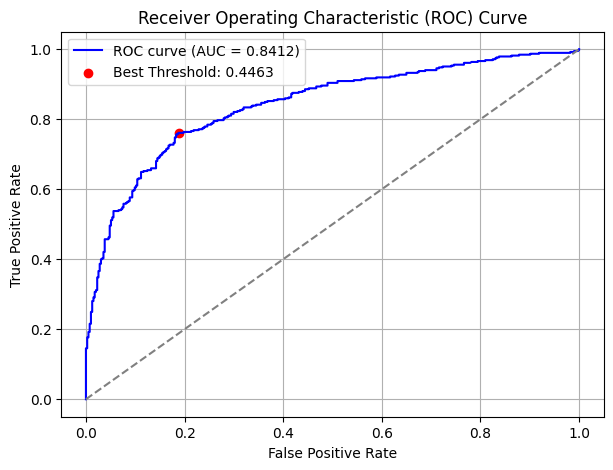

Test Accuracy: 0.7177 (Using Threshold: 0.4463)
Precision: 0.7290, Recall: 0.7222, F1-Score: 0.7256


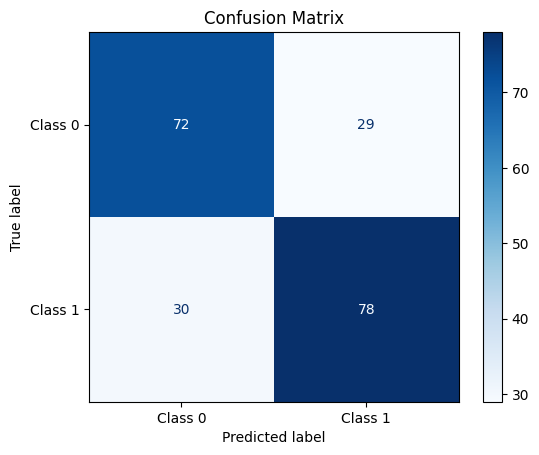

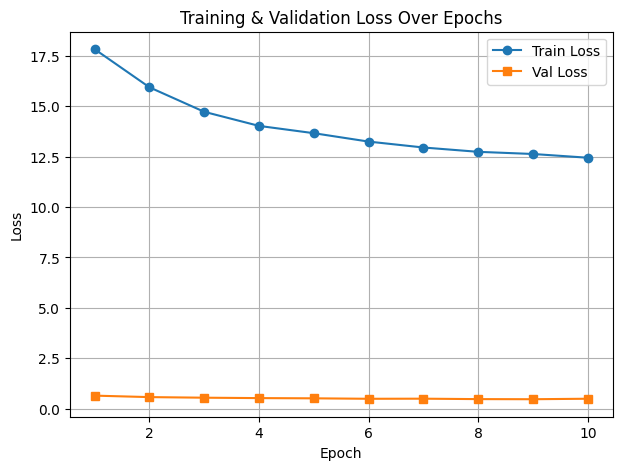

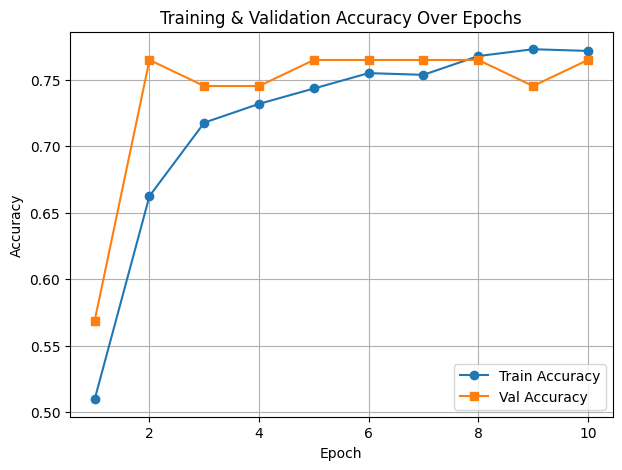

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from benchmark_ResNet18 import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model with feature extraction
model = make_model("resnet18", feature_extracting=True, use_pretrained=True).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Testing the benchmark model used in the paper but increasing the number of epochs from 10 to 20 of ibionet where they used the ResNet18 to trained their model withouth feature extraction (all model is being retrained)

Using device: mps


/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 - Loss: 13.6214, Train Acc: 0.7330, Val Acc: 0.7647, Val Loss: 0.4929
Epoch 2/30 - Loss: 12.1730, Train Acc: 0.7677, Val Acc: 0.8039, Val Loss: 0.5344
Epoch 3/30 - Loss: 12.1975, Train Acc: 0.7972, Val Acc: 0.6863, Val Loss: 0.6589
Epoch 4/30 - Loss: 12.0359, Train Acc: 0.7882, Val Acc: 0.7843, Val Loss: 0.5198
Epoch 5/30 - Loss: 10.5985, Train Acc: 0.8228, Val Acc: 0.7647, Val Loss: 0.4479
Epoch 6/30 - Loss: 9.5687, Train Acc: 0.8344, Val Acc: 0.7647, Val Loss: 0.5405
Epoch 7/30 - Loss: 8.7590, Train Acc: 0.8652, Val Acc: 0.8039, Val Loss: 0.4468
Epoch 8/30 - Loss: 8.2484, Train Acc: 0.8742, Val Acc: 0.6471, Val Loss: 0.9730
Epoch 9/30 - Loss: 11.7516, Train Acc: 0.7946, Val Acc: 0.8235, Val Loss: 0.3948
Epoch 10/30 - Loss: 8.3513, Train Acc: 0.8575, Val Acc: 0.8627, Val Loss: 0.3582
Epoch 11/30 - Loss: 5.9554, Train Acc: 0.9140, Val Acc: 0.8431, Val Loss: 0.4369
Epoch 12/30 - Loss: 4.6322, Train Acc: 0.9281, Val Acc: 0.8824, Val Loss: 0.4604
Epoch 13/30 - Loss: 3.5181, Tra

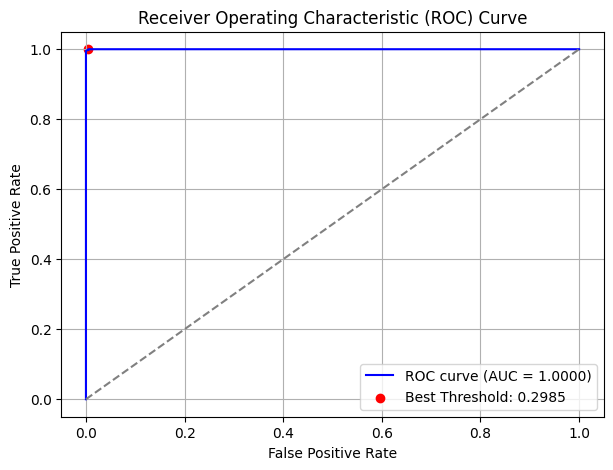

Test Accuracy: 0.7608 (Using Threshold: 0.2985)
Precision: 0.7685, Recall: 0.7685, F1-Score: 0.7685


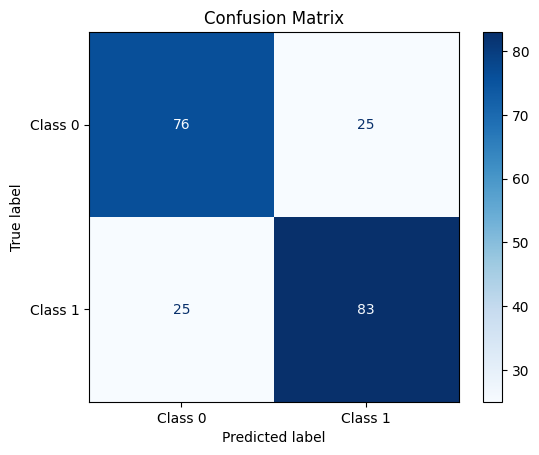

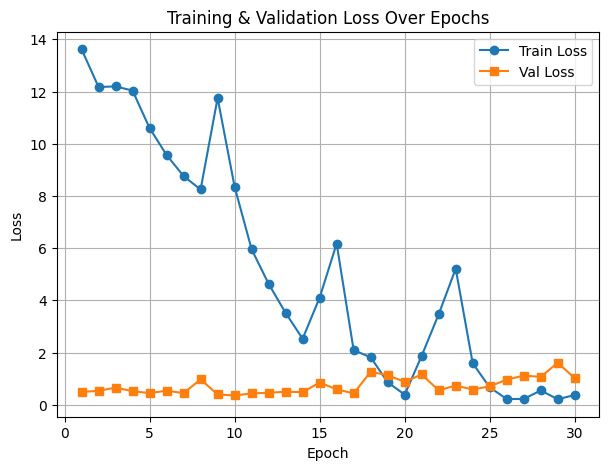

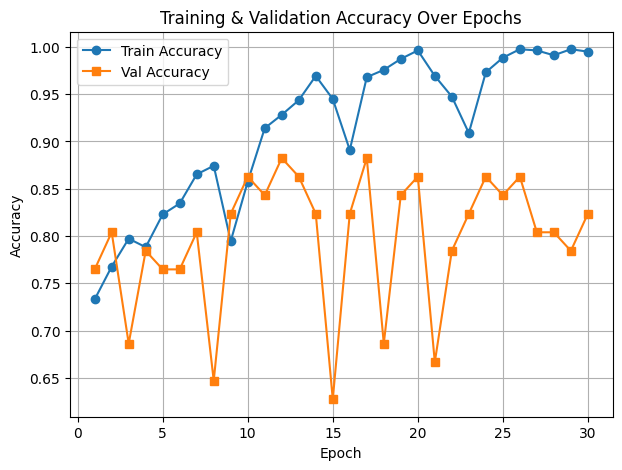

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from benchmark_ResNet18 import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Graph Neural Network for binary prediction (tumor proteins)

/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Using device: mps
Epoch 1/30 - Loss: 17.0358, Train Acc: 0.5814, Val Acc: 0.6923, Val Loss: 0.6737
Epoch 2/30 - Loss: 16.6840, Train Acc: 0.6590, Val Acc: 0.6923, Val Loss: 0.6445
Epoch 3/30 - Loss: 16.1597, Train Acc: 0.7137, Val Acc: 0.7115, Val Loss: 0.6335
Epoch 4/30 - Loss: 15.6039, Train Acc: 0.7303, Val Acc: 0.7500, Val Loss: 0.6046
Epoch 5/30 - Loss: 14.9875, Train Acc: 0.7341, Val Acc: 0.6923, Val Loss: 0.5940
Epoch 6/30 - Loss: 14.3573, Train Acc: 0.7379, Val Acc: 0.6731, Val Loss: 0.5782
Epoch 7/30 - Loss: 13.9429, Train Acc: 0.7303, Val Acc: 0.6731, Val Loss: 0.5803
Epoch 8/30 - Loss: 13.7896, Train Acc: 0.7328, Val Acc: 0.6731, Val Loss: 0.5670
Epoch 9/30 - Loss: 13.2501, Train Acc: 0.7417, Val Acc: 0.7115, Val Loss: 0.5763
Epoch 10/30 - Loss: 13.1266, Train Acc: 0.7455, Val Acc: 0.7115, Val Loss: 0.6061
Epoch 11/30 - Loss: 13.0109, Train Acc: 0.7506, Val Acc: 0.7115, Val Loss: 0.5632
Epoch 12/30 - Loss: 12.9274, Train Acc: 0.7405, Val Acc: 0.7115, Val Loss: 0.5611
Epoch 1

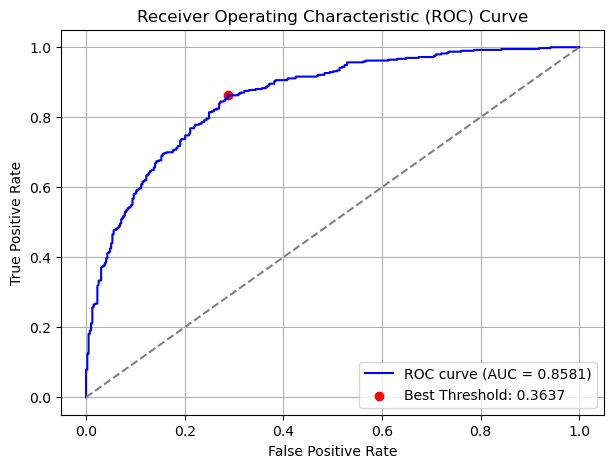

Test Accuracy: 0.7905 (Using Threshold: 0.3637)
Precision: 0.7638, Recall: 0.8739, F1-Score: 0.8151


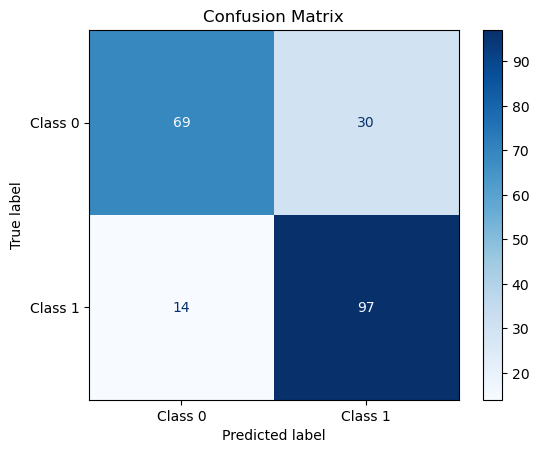

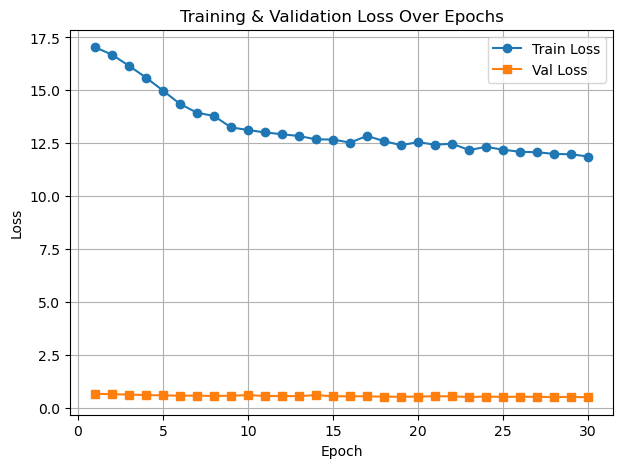

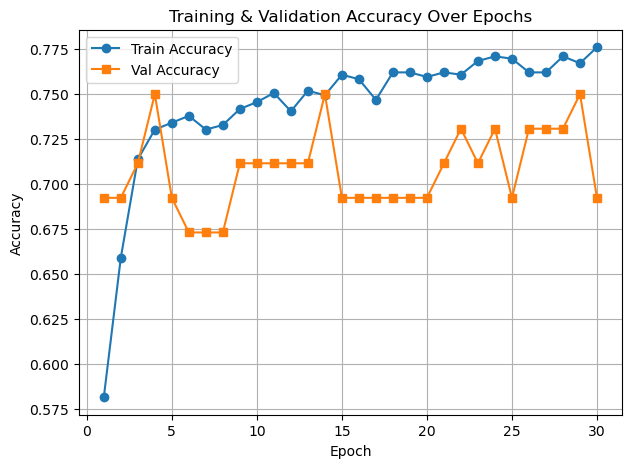

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader as GeometricDataLoader
from gnn_model import GNN  # Import the GNN model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/graph_datasets/test_set.pth", weights_only=False)


# Create GNN DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize GNN model
input_dim, hidden_dim, output_dim = 3, 64, 1  # RGB channels as node features
model = GNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Graph Neural Network with two more hidden layers (tumor proteins)

/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Using device: mps
Epoch 1/30 - Loss: 16.9611, Train Acc: 0.5891, Val Acc: 0.4808, Val Loss: 0.6917
Epoch 2/30 - Loss: 16.3086, Train Acc: 0.6578, Val Acc: 0.5962, Val Loss: 0.6744
Epoch 3/30 - Loss: 15.6328, Train Acc: 0.6908, Val Acc: 0.4808, Val Loss: 0.7010
Epoch 4/30 - Loss: 14.9551, Train Acc: 0.6908, Val Acc: 0.6538, Val Loss: 0.6312
Epoch 5/30 - Loss: 14.6367, Train Acc: 0.7137, Val Acc: 0.5769, Val Loss: 0.6696
Epoch 6/30 - Loss: 14.2771, Train Acc: 0.7303, Val Acc: 0.6731, Val Loss: 0.6022
Epoch 7/30 - Loss: 14.3533, Train Acc: 0.7087, Val Acc: 0.6923, Val Loss: 0.6152
Epoch 8/30 - Loss: 13.9804, Train Acc: 0.7125, Val Acc: 0.6923, Val Loss: 0.6304
Epoch 9/30 - Loss: 14.5345, Train Acc: 0.6883, Val Acc: 0.6731, Val Loss: 0.6362
Epoch 10/30 - Loss: 14.1453, Train Acc: 0.7036, Val Acc: 0.7115, Val Loss: 0.5768
Epoch 11/30 - Loss: 13.9375, Train Acc: 0.7328, Val Acc: 0.6538, Val Loss: 0.5933
Epoch 12/30 - Loss: 13.6421, Train Acc: 0.7201, Val Acc: 0.6154, Val Loss: 0.6323
Epoch 1

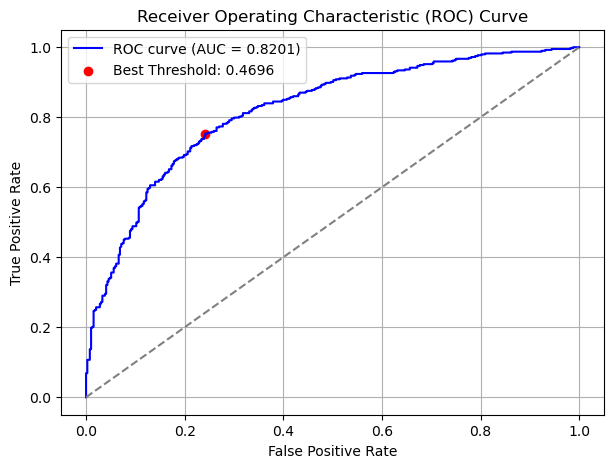

Test Accuracy: 0.7429 (Using Threshold: 0.4696)
Precision: 0.7355, Recall: 0.8018, F1-Score: 0.7672


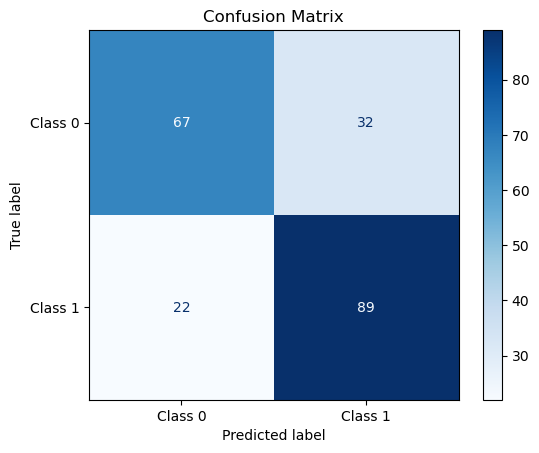

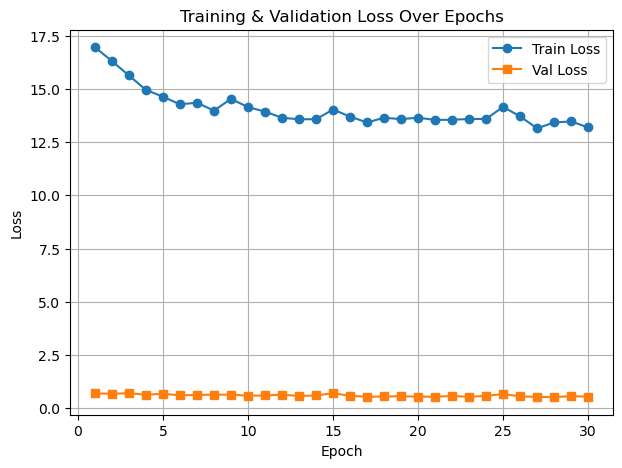

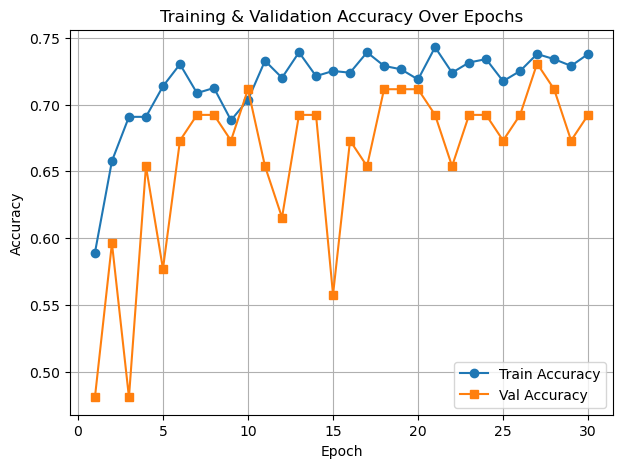

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader as GeometricDataLoader

# Properly reload the module
import importlib
import gnn2_model  # Import the module first
importlib.reload(gnn2_model)
from gnn2_model import GNN  # Now import the class after reloading

from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Create GNN DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize GNN model
input_dim, hidden_dim, output_dim = 3, 64, 1  # RGB channels as node features
model = GNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()


# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Graph Neural Network 

Using device: mps


/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Loss: 35.7663, Train Acc: 0.5585, Val Acc: 0.6538, Val Loss: 0.6376, LR: 0.030000
Epoch 2/50 - Loss: 16.5591, Train Acc: 0.6476, Val Acc: 0.5577, Val Loss: 0.7366, LR: 0.030000
Epoch 3/50 - Loss: 15.4967, Train Acc: 0.6845, Val Acc: 0.7308, Val Loss: 0.6075, LR: 0.030000
Epoch 4/50 - Loss: 14.7140, Train Acc: 0.7074, Val Acc: 0.6923, Val Loss: 0.6354, LR: 0.030000
Epoch 5/50 - Loss: 14.5710, Train Acc: 0.7277, Val Acc: 0.7115, Val Loss: 0.5472, LR: 0.030000
Epoch 6/50 - Loss: 14.2988, Train Acc: 0.7163, Val Acc: 0.7500, Val Loss: 0.5603, LR: 0.030000
Epoch 7/50 - Loss: 13.2948, Train Acc: 0.7583, Val Acc: 0.7308, Val Loss: 0.5469, LR: 0.030000
Epoch 8/50 - Loss: 13.3617, Train Acc: 0.7379, Val Acc: 0.6731, Val Loss: 0.6384, LR: 0.030000
Epoch 9/50 - Loss: 13.4384, Train Acc: 0.7405, Val Acc: 0.7308, Val Loss: 0.5798, LR: 0.030000
Epoch 10/50 - Loss: 14.3673, Train Acc: 0.7201, Val Acc: 0.7692, Val Loss: 0.5193, LR: 0.030000
Epoch 11/50 - Loss: 13.3643, Train Acc: 0.7608, V

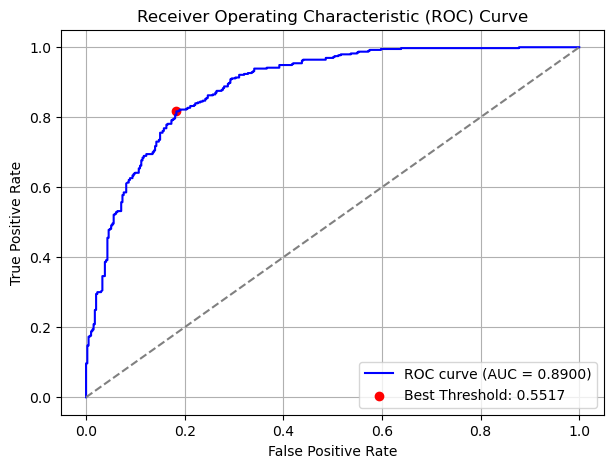

: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from gnn_model import GNN
import torch
from torch.utils.data.dataset import Subset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Define DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Get input feature size from dataset
input_dim = train_set[0].x.shape[1]  
hidden_dim = 256
output_dim = 1  # Binary classification

# Initialize GNN model
model = GNN(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=0.0001)

# **Learning Rate Scheduler**
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Step the scheduler
        scheduler.step(val_loss)

        # Get current learning rate
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

    return correct / total, running_loss / len(val_loader)

# Train model with scheduler
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

Do the previous code but with gnn2 which has more layers. lower the learning rate (0.003) and the epochs (30)

Using device: mps
Epoch 1/30 - Loss: 17.2693, Train Acc: 0.5712, Val Acc: 0.6538, Val Loss: 0.6425, LR: 0.003000
Epoch 2/30 - Loss: 16.2998, Train Acc: 0.6361, Val Acc: 0.6346, Val Loss: 0.6598, LR: 0.003000
Epoch 3/30 - Loss: 15.4384, Train Acc: 0.6768, Val Acc: 0.7308, Val Loss: 0.5829, LR: 0.003000
Epoch 4/30 - Loss: 14.7797, Train Acc: 0.7036, Val Acc: 0.4808, Val Loss: 0.7838, LR: 0.003000
Epoch 5/30 - Loss: 16.0295, Train Acc: 0.6641, Val Acc: 0.6346, Val Loss: 0.6423, LR: 0.003000
Epoch 6/30 - Loss: 15.5776, Train Acc: 0.6552, Val Acc: 0.6538, Val Loss: 0.6387, LR: 0.001500
Epoch 7/30 - Loss: 15.1595, Train Acc: 0.6819, Val Acc: 0.7115, Val Loss: 0.5947, LR: 0.001500
Epoch 8/30 - Loss: 14.4390, Train Acc: 0.7150, Val Acc: 0.6538, Val Loss: 0.6151, LR: 0.001500
Epoch 9/30 - Loss: 14.2409, Train Acc: 0.7036, Val Acc: 0.6731, Val Loss: 0.6260, LR: 0.000750
Epoch 10/30 - Loss: 13.4655, Train Acc: 0.7366, Val Acc: 0.6731, Val Loss: 0.5950, LR: 0.000750
Epoch 11/30 - Loss: 13.7863, Tr

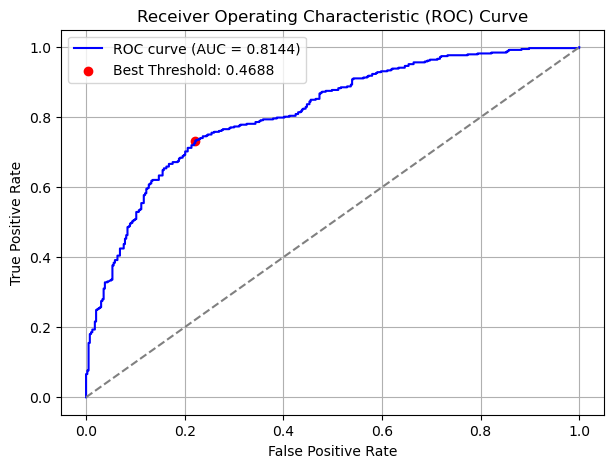

: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from gnn2_model import GNN
import torch
from torch.utils.data.dataset import Subset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Define DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Get input feature size from dataset
input_dim = train_set[0].x.shape[1]  
hidden_dim = 256
output_dim = 1  # Binary classification

# Initialize GNN model
model = GNN(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)

# **Learning Rate Scheduler**
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Step the scheduler
        scheduler.step(val_loss)

        # Get current learning rate
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

    return correct / total, running_loss / len(val_loader)

# Train model with scheduler
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)


# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

The model is still failing to learn, I will try a CNN to see if it works better or if the only reason the first two worked better is because it's a very complex architecture and doesn't take too long because it is transferred learning

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

# Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 32 filters
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128 filters
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Assuming 224x224 input
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            nn.Linear(512, 1)  # Binary classification output
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize CNN model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Using device: mps
Epoch 1/10 - Loss: 100.3043, Train Acc: 0.6226, Val Acc: 0.7451, Val Loss: 1.0324
Epoch 2/10 - Loss: 20.9612, Train Acc: 0.7214, Val Acc: 0.7451, Val Loss: 0.6669
Epoch 3/10 - Loss: 10.9436, Train Acc: 0.8049, Val Acc: 0.7843, Val Loss: 0.4357
Epoch 4/10 - Loss: 8.8113, Train Acc: 0.8665, Val Acc: 0.7255, Val Loss: 0.5488
Epoch 5/10 - Loss: 7.0916, Train Acc: 0.8999, Val Acc: 0.7451, Val Loss: 0.5209
Epoch 6/10 - Loss: 5.8204, Train Acc: 0.9217, Val Acc: 0.7647, Val Loss: 0.5034
Epoch 7/10 - Loss: 3.2792, Train Acc: 0.9692, Val Acc: 0.7451, Val Loss: 0.5947
Epoch 8/10 - Loss: 2.2286, Train Acc: 0.9846, Val Acc: 0.7255, Val Loss: 0.7364
Epoch 9/10 - Loss: 1.5653, Train Acc: 0.9872, Val Acc: 0.8235, Val Loss: 0.5529
Epoch 10/10 - Loss: 0.7754, Train Acc: 0.9987, Val Acc: 0.7647, Val Loss: 0.6337


Based on the previous architecture we can see that we don't need a very complex architecture to get the same results (Resnet Results were: Epoch 30/30 - Loss: 0.3731, Train Acc: 0.9949, Val Acc: 0.8235, Val Loss: 1.0171) as we got from the Resnet which is more robust and significantly more complex.

Because the GNN did not perform well:

Epoch 30/30 - Loss: 12.8415, Train Acc: 0.7445, Val Acc: 0.7647, Val Loss: 0.5048 in 114 minutes. And the model plateaud basically somewhere around epoch 9. Although we do see that the GNN does not overfit as the training accuracy is the same as the validation accuracy.


Now we will escalate the previous CNN but for multiclass classification. We wil add bacterial antigens and bacterial non antigens

Generate the train, test and validation set on the multiclass classification

In [ ]:
import os
import glob
import random
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch_geometric.data import Data
import shutil  # For copying files

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set relative paths to datasets
data_dir_immunogenic = "tumor_antigens_immunogenic/voronoi_images"
data_dir_non_immunogenic = "tumor_antigens_non-immunogenic/voronoi_images"
data_dir_bacterial_immunogenic = "bacterial_antigens/voronoi_images"
data_dir_bacterial_non_immunogenic = "bacterial_non_antigens/voronoi_images"

# Root dataset directory (must contain only image folders)
root_dir = "multiclass_dataset"
multiclass = os.path.join(root_dir, "multiclass")

tumor_immunogenic_dir = os.path.join(multiclass, "tumor_immunogenic")
tumor_non_immunogenic_dir = os.path.join(multiclass, "tumor_non_immunogenic")
bacterial_immunogenic_dir = os.path.join(multiclass, "bacterial_immunogenic")
bacterial_non_immunogenic_dir = os.path.join(multiclass, "bacterial_non_immunogenic")

# Separate directories for saving dataset splits
image_data_dir = os.path.join(root_dir, "image_datasets")


# Ensure only image-containing directories exist before calling ImageFolder
os.makedirs(tumor_immunogenic_dir, exist_ok=True)
os.makedirs(tumor_non_immunogenic_dir, exist_ok=True)
os.makedirs(bacterial_immunogenic_dir, exist_ok=True)
os.makedirs(bacterial_non_immunogenic_dir, exist_ok=True)

# Ensure dataset folders exist for saving train/val/test splits
os.makedirs(image_data_dir, exist_ok=True)

# Copy images into class-labeled folders **only if they are not already copied**
if not os.listdir(tumor_immunogenic_dir) or not os.listdir(tumor_non_immunogenic_dir) or not os.listdir(bacterial_immunogenic_dir) or not os.listdir(bacterial_non_immunogenic_dir):
    print("Copying images into class-labeled folders...")
    for src_dir, dst_dir in [
        (data_dir_immunogenic, tumor_immunogenic_dir),
        (data_dir_non_immunogenic, tumor_non_immunogenic_dir),
        (data_dir_bacterial_immunogenic, bacterial_immunogenic_dir),
        (data_dir_bacterial_non_immunogenic, bacterial_non_immunogenic_dir),
    ]:
        for img_path in glob.glob(os.path.join(src_dir, "*.png")):
            shutil.copy(img_path, os.path.join(dst_dir, os.path.basename(img_path)))  # Copy instead of move
    print("Dataset successfully copied and organized.")
else:
    print("Dataset already organized. Skipping file copy.")

# Ensure dataset folders are not empty before proceeding
if not os.listdir(tumor_immunogenic_dir) or not os.listdir(tumor_non_immunogenic_dir) or not os.listdir(bacterial_immunogenic_dir) or not os.listdir(bacterial_non_immunogenic_dir):
    raise FileNotFoundError("Error: One or more class directories are empty.")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Check if dataset files already exist before processing
train_set_path = os.path.join(image_data_dir, "train_set.pth")
val_set_path = os.path.join(image_data_dir, "val_set.pth")
test_set_path = os.path.join(image_data_dir, "test_set.pth")

if not (os.path.exists(train_set_path) and os.path.exists(val_set_path) and os.path.exists(test_set_path)):
    print("Processing image dataset...")
    dataset = ImageFolder(root=multiclass, transform=transform)  # Set the correct root directory

    # Split dataset into train (75%), validation (5%), and test (20%)
    train_size = int(0.75 * len(dataset))
    val_size = int(0.05 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Save dataset splits
    torch.save(train_set, train_set_path)
    torch.save(val_set, val_set_path)
    torch.save(test_set, test_set_path)
    print(f"Image dataset saved in {image_data_dir}. Train: {train_size}, Val: {val_size}, Test: {test_size}")
else:
    print("Image dataset already processed. Skipping dataset split.")


# Load saved datasets correctly
from torch.utils.data import Subset

# Use Safe Globals to Allow Subset Objects
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load(os.path.join(image_data_dir, "train_set.pth"), weights_only=False)
    val_set = torch.load(os.path.join(image_data_dir, "val_set.pth"), weights_only=False)
    test_set = torch.load(os.path.join(image_data_dir, "test_set.pth"), weights_only=False)


print(f"Train Samples: {len(train_set)}, Val Samples: {len(val_set)}, Test Samples: {len(test_set)}")


Dataset already organized. Skipping file copy.
Image dataset already processed. Skipping dataset split.
Train Samples: 1175, Val Samples: 78, Test Samples: 314


Generate the train, test and validation set on the multiclass classification for the graphs

In [ ]:
import os
import torch
import random
import torch_geometric
from torch_geometric.data import Data

# Allow PyTorch Geometric data types for safe unpickling
torch.serialization.add_safe_globals([
    torch_geometric.data.Data,  # Standard PyG data class
    torch_geometric.data.Batch,  # If you're using batch processing
])

# Set seed for reproducibility
random.seed(42)

# Define paths
base_dir = os.getcwd()  # Assumes script is in the same directory
paths = {
    "immunogenic": os.path.join(base_dir, "tumor_antigens_immunogenic", "graphs"),
    "non_immunogenic": os.path.join(base_dir, "tumor_antigens_non-immunogenic", "graphs"),
    "bacterial_non_antigens": os.path.join(base_dir, "bacterial_non_antigens", "graphs"),
    "bacterial_antigens": os.path.join(base_dir, "bacterial_antigens", "graphs")
}

# Assign class labels (modify as needed)
class_labels = {
    "immunogenic": 0,
    "non_immunogenic": 1,
    "bacterial_non_antigens": 2,
    "bacterial_antigens": 3
}

# Destination folder for the output datasets
output_dir = os.path.join(base_dir, "multiclass_dataset", "graph_datasets")
os.makedirs(output_dir, exist_ok=True)  # Create directories if they don't exist

# Load file paths and assign labels
data = []
label_counts = {label: 0 for label in class_labels.values()}  # Initialize label counters

for category, path in paths.items():
    if os.path.exists(path):  # Ensure directory exists
        files = [(os.path.join(path, f), class_labels[category]) for f in os.listdir(path) if f.endswith(".pth")]
        data.extend(files)
        label_counts[class_labels[category]] += len(files)

# Shuffle dataset
random.shuffle(data)

# Split dataset
total = len(data)
train_size = int(0.75 * total)
val_size = int(0.05 * total)
test_size = total - train_size - val_size  # Ensures the sum is total

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Function to save dataset and count labels
def save_dataset(data, filename):
    dataset = []
    local_label_counts = {label: 0 for label in class_labels.values()}  # Initialize per-set label counters

    for file_path, label in data:
        graph_data = torch.load(file_path, weights_only=False)  # Load PyG Data object
        graph_data.y = torch.tensor([label], dtype=torch.long)  # Store label inside the Data object
        dataset.append(graph_data)

        # Count labels
        local_label_counts[label] += 1  

    torch.save(dataset, os.path.join(output_dir, filename))
    return local_label_counts  # Return label distribution for this dataset

# Save datasets and count labels
train_counts = save_dataset(train_data, "train_set.pth")
val_counts = save_dataset(val_data, "val_set.pth")
test_counts = save_dataset(test_data, "test_set.pth")

# Print dataset sizes and label distribution
print(f"\nTraining samples: {len(train_data)}")
for label, count in train_counts.items():
    print(f"  Class {label}: {count}")

print(f"\nValidation samples: {len(val_data)}")
for label, count in val_counts.items():
    print(f"  Class {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
for label, count in test_counts.items():
    print(f"  Class {label}: {count}")

print(f"\nDatasets saved in {output_dir}")



Training samples: 1182
  Class 0: 386
  Class 1: 409
  Class 2: 233
  Class 3: 154

Validation samples: 78
  Class 0: 29
  Class 1: 22
  Class 2: 17
  Class 3: 10

Test samples: 316
  Class 0: 113
  Class 1: 89
  Class 2: 63
  Class 3: 51

Datasets saved in /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/graph_datasets


Class 0: Tumor Immunogenic (520)
Class 1: Tumor Non-Immunogenic (528)
Class 2: Bacterial Non-Immunogenic (314)
Class 3: Bacterial Immunogenic (215)

Now that we have the multiclass dataset we will run the previous CNN and see how it performs

Using device: mps
Epoch 1/10 - Loss: 276.8586, Train Acc: 0.3506, Val Acc: 0.4359, Val Loss: 1.4147
Epoch 2/10 - Loss: 33.4620, Train Acc: 0.6213, Val Acc: 0.5513, Val Loss: 0.9653
Epoch 3/10 - Loss: 20.7768, Train Acc: 0.7736, Val Acc: 0.7051, Val Loss: 0.5885
Epoch 4/10 - Loss: 16.0054, Train Acc: 0.8196, Val Acc: 0.6795, Val Loss: 0.6385
Epoch 5/10 - Loss: 10.8364, Train Acc: 0.8970, Val Acc: 0.7051, Val Loss: 0.6638
Epoch 6/10 - Loss: 8.6639, Train Acc: 0.9166, Val Acc: 0.7051, Val Loss: 0.6305
Epoch 7/10 - Loss: 5.5611, Train Acc: 0.9600, Val Acc: 0.7436, Val Loss: 0.5927
Epoch 8/10 - Loss: 5.2949, Train Acc: 0.9591, Val Acc: 0.7308, Val Loss: 0.6508
Epoch 9/10 - Loss: 2.9325, Train Acc: 0.9838, Val Acc: 0.7308, Val Loss: 0.6968
Epoch 10/10 - Loss: 1.6963, Train Acc: 0.9923, Val Acc: 0.7179, Val Loss: 0.7817
Test Accuracy: 0.7420
Precision: 0.7572, Recall: 0.7420, F1-Score: 0.7341


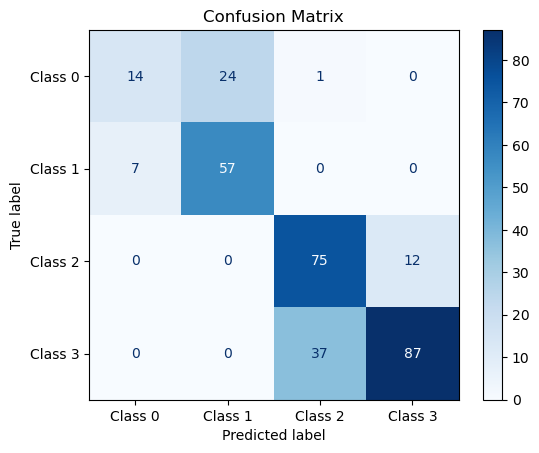

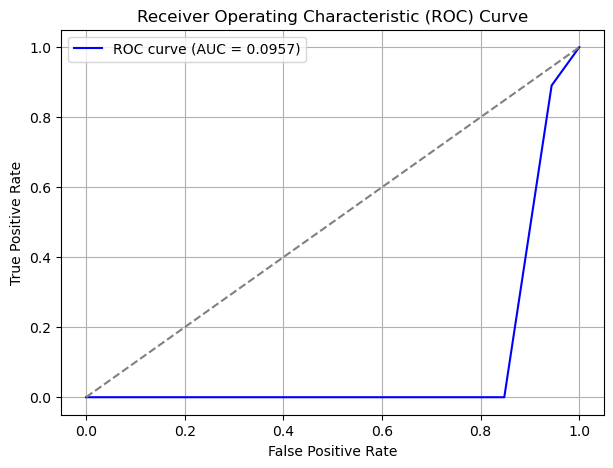

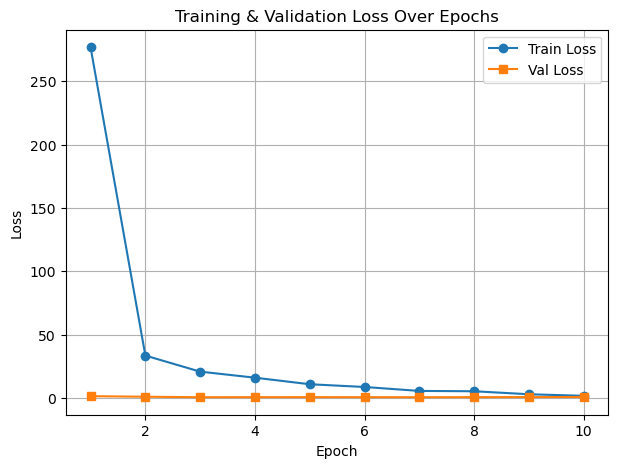

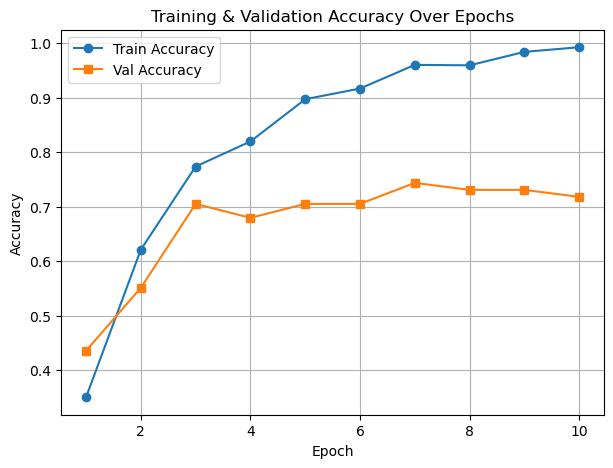

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):  # Change to 4 classes
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Output 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize CNN model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Initialize lists for tracking losses and accuracy for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Change to long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # No need for unsqueeze(1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Test function using best threshold
def test_model(model, test_loader):
    """Evaluate the model on the test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve (multi-class)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Test model
test_model(model, test_loader)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


In the following code I use the previous multiclass CNN but on hte new augmented dataset:

Using device: mps
Epoch 1/10 - Loss: 435.2206, Train Acc: 0.3850, Val Acc: 0.4809, Val Loss: 1.2359
Epoch 2/10 - Loss: 133.1130, Train Acc: 0.4896, Val Acc: 0.4468, Val Loss: 1.2139
Epoch 3/10 - Loss: 123.8285, Train Acc: 0.5345, Val Acc: 0.5149, Val Loss: 1.1351
Epoch 4/10 - Loss: 110.3289, Train Acc: 0.5923, Val Acc: 0.4894, Val Loss: 1.2003
Epoch 5/10 - Loss: 96.8192, Train Acc: 0.6409, Val Acc: 0.4979, Val Loss: 1.1275
Epoch 6/10 - Loss: 83.2809, Train Acc: 0.6840, Val Acc: 0.4979, Val Loss: 1.1519
Epoch 7/10 - Loss: 67.0213, Train Acc: 0.7614, Val Acc: 0.4936, Val Loss: 1.4014
Epoch 8/10 - Loss: 51.8577, Train Acc: 0.8199, Val Acc: 0.4851, Val Loss: 1.5249
Epoch 9/10 - Loss: 37.8733, Train Acc: 0.8738, Val Acc: 0.4511, Val Loss: 1.6866
Epoch 10/10 - Loss: 26.7475, Train Acc: 0.9180, Val Acc: 0.4596, Val Loss: 2.1556
Test Accuracy: 0.5292
Precision: 0.5278, Recall: 0.5292, F1-Score: 0.5153


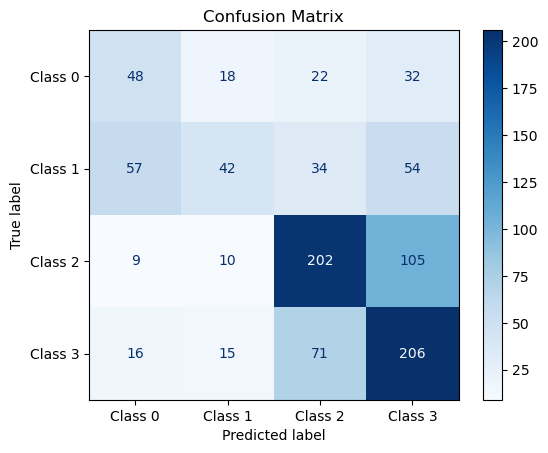

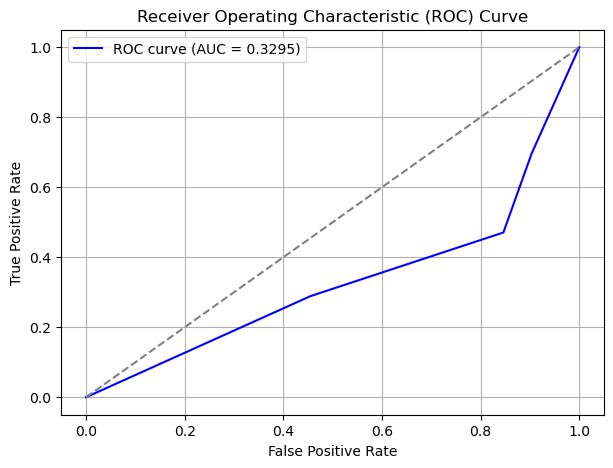

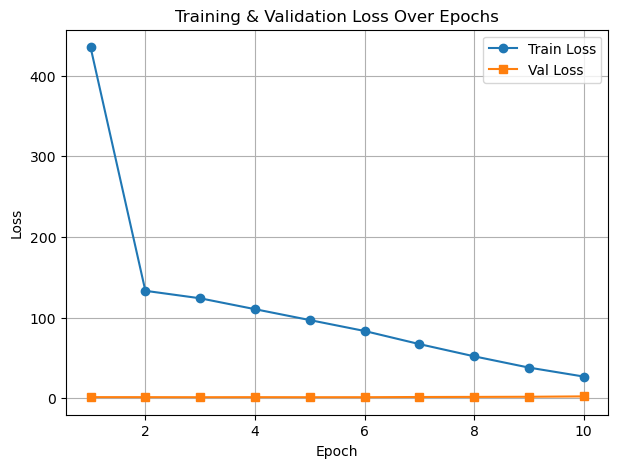

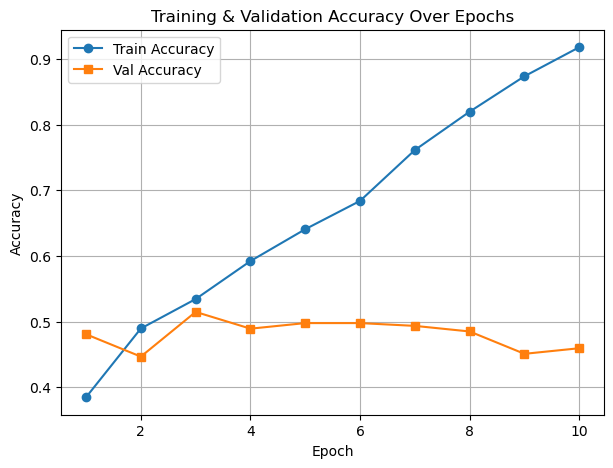

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):  # Change to 4 classes
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Output 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("data_augmented_multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("data_augmented_multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("data_augmented_multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize CNN model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Initialize lists for tracking losses and accuracy for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()  # Change to long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # No need for unsqueeze(1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Test function using best threshold
def test_model(model, test_loader):
    """Evaluate the model on the test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve (multi-class)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Test model
test_model(model, test_loader)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

THe model kept overfitting even with an augmented dataset. So I balanced the augmented dataset

Using device: mps
Epoch 1/50 - Loss: 2991.5121, Train Acc: 0.2516, Val Acc: 0.2851, Val Loss: 1.3854
Epoch 2/50 - Loss: 153.9413, Train Acc: 0.2417, Val Acc: 0.2851, Val Loss: 1.3868
Epoch 3/50 - Loss: 154.0382, Train Acc: 0.2451, Val Acc: 0.3489, Val Loss: 1.3841
Epoch 4/50 - Loss: 153.9149, Train Acc: 0.2519, Val Acc: 0.2128, Val Loss: 1.3875
Epoch 5/50 - Loss: 154.5977, Train Acc: 0.2576, Val Acc: 0.2128, Val Loss: 1.3863
Epoch 6/50 - Loss: 154.3307, Train Acc: 0.2508, Val Acc: 0.1532, Val Loss: 1.3897
Epoch 7/50 - Loss: 154.1699, Train Acc: 0.2536, Val Acc: 0.1532, Val Loss: 1.3887
Epoch 8/50 - Loss: 153.8096, Train Acc: 0.2562, Val Acc: 0.3489, Val Loss: 1.3867
Epoch 9/50 - Loss: 153.9688, Train Acc: 0.2462, Val Acc: 0.1532, Val Loss: 1.3870
Epoch 10/50 - Loss: 153.8524, Train Acc: 0.2548, Val Acc: 0.1532, Val Loss: 1.3868
Epoch 11/50 - Loss: 153.9221, Train Acc: 0.2335, Val Acc: 0.1532, Val Loss: 1.3868
Epoch 12/50 - Loss: 153.9093, Train Acc: 0.2550, Val Acc: 0.1532, Val Loss: 1

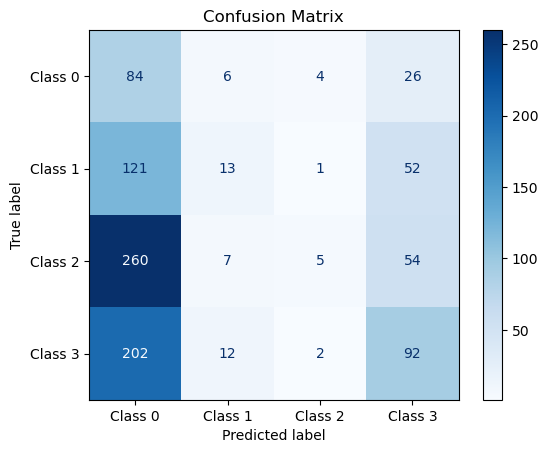

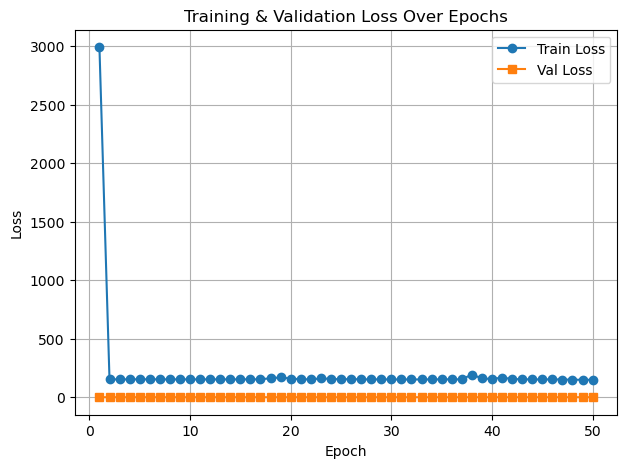

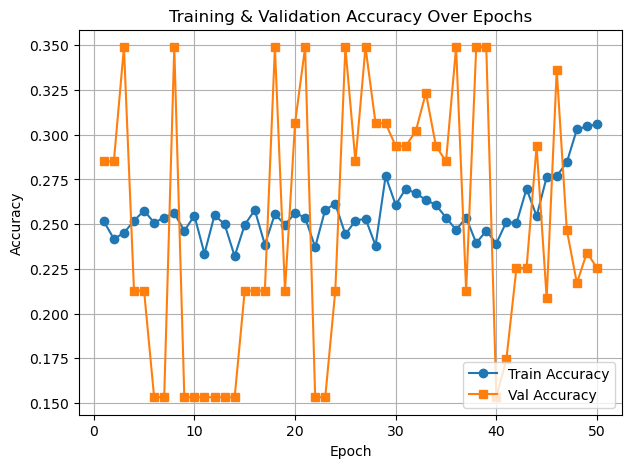

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR

# Custom CNN Model with Dropout
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
    

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("data_augmented_multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("data_augmented_multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("data_augmented_multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Compute class weights for oversampling
labels = [label for _, label in train_set]
class_counts = Counter(labels)
num_samples = len(labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Track losses and accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Early stopping variables
early_stop_patience = 10
no_improve_epochs = 0
best_val_loss = float('inf')

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    global no_improve_epochs, best_val_loss
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        scheduler.step()

        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Test function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Run training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
test_model(model, test_loader)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


After this previous result I decide to do the ResNet with no freezing layers but now on multiclass classification as this was the model that best performed in binary classification.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from benchmark_ResNet18_multiclass import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)

# Define loss function and optimizer (now Cross Entropy for multiclass)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if epoch == 0 and batch_idx == 0:
                print("Output shape:", outputs.shape)
                print("Sample logits:", outputs[0])
                print("Label shape:", labels.shape)
                print("Sample labels:", labels[:10])
                print("Unique labels in batch:", labels.unique())

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        train_losses.append(running_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


# Validation function


def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1) #changed from sigmoid to argmax

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Using device: mps
Output shape: torch.Size([32, 4])
Sample logits: tensor([ 0.5175,  1.2676, -0.5655,  0.1224], device='mps:0',
       grad_fn=<SelectBackward0>)
Label shape: torch.Size([32])
Sample labels: tensor([1, 2, 1, 0, 0, 3, 2, 3, 3, 1], device='mps:0')
Unique labels in batch: tensor([0, 1, 2, 3], device='mps:0')
Epoch 1/10 - Loss: 26.6792, Train Acc: 0.6613, Val Acc: 0.6026, Val Loss: 0.8202
Epoch 2/10 - Loss: 13.8981, Train Acc: 0.8426, Val Acc: 0.6795, Val Loss: 0.5635
Epoch 3/10 - Loss: 8.3447, Train Acc: 0.9140, Val Acc: 0.5897, Val Loss: 1.1142
Epoch 4/10 - Loss: 2.6232, Train Acc: 0.9821, Val Acc: 0.7436, Val Loss: 0.7679
Epoch 5/10 - Loss: 2.6298, Train Acc: 0.9813, Val Acc: 0.7564, Val Loss: 1.0527
Epoch 6/10 - Loss: 1.3101, Train Acc: 0.9906, Val Acc: 0.7308, Val Loss: 1.0598
Epoch 7/10 - Loss: 1.4380, Train Acc: 0.9872, Val Acc: 0.7308, Val Loss: 1.3467
Epoch 8/10 - Loss: 3.2325, Train Acc: 0.9694, Val Acc: 0.7436, Val Loss: 1.1480
Epoch 9/10 - Loss: 3.2901, Train Ac

ValueError: multiclass format is not supported

11.	Finally, I tried the ResNet18 pretrained model but with oversampling of the undersampled class and the data augmentation.

Using device: mps


/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Loss: 118.6642, Train Acc: 0.6037, Val Acc: 0.4213, Val Loss: 1.4472
Epoch 2/50 - Loss: 84.3920, Train Acc: 0.7929, Val Acc: 0.4809, Val Loss: 1.4314
Epoch 3/50 - Loss: 70.7739, Train Acc: 0.8670, Val Acc: 0.6298, Val Loss: 1.0705
Epoch 4/50 - Loss: 59.2730, Train Acc: 0.9223, Val Acc: 0.6851, Val Loss: 0.9758
Epoch 5/50 - Loss: 51.1628, Train Acc: 0.9682, Val Acc: 0.6979, Val Loss: 0.9251
Epoch 6/50 - Loss: 46.5552, Train Acc: 0.9847, Val Acc: 0.7106, Val Loss: 0.8328
Epoch 7/50 - Loss: 43.3277, Train Acc: 0.9949, Val Acc: 0.7362, Val Loss: 0.8060
Epoch 8/50 - Loss: 42.1940, Train Acc: 0.9963, Val Acc: 0.7447, Val Loss: 0.7988
Epoch 9/50 - Loss: 41.6915, Train Acc: 0.9986, Val Acc: 0.7319, Val Loss: 0.8125
Epoch 10/50 - Loss: 41.1597, Train Acc: 0.9986, Val Acc: 0.7277, Val Loss: 0.8111
Epoch 11/50 - Loss: 40.9514, Train Acc: 0.9986, Val Acc: 0.7234, Val Loss: 0.8198
Epoch 12/50 - Loss: 40.9828, Train Acc: 0.9986, Val Acc: 0.7319, Val Loss: 0.8183
Epoch 13/50 - Loss: 40.8

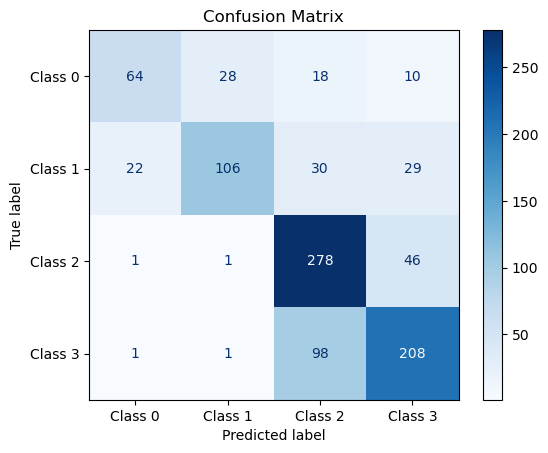

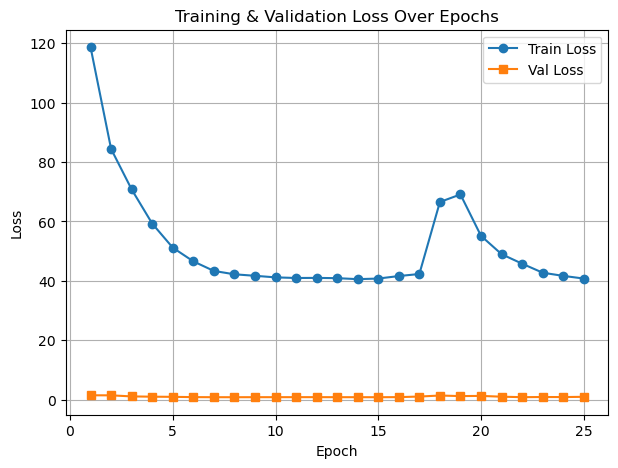

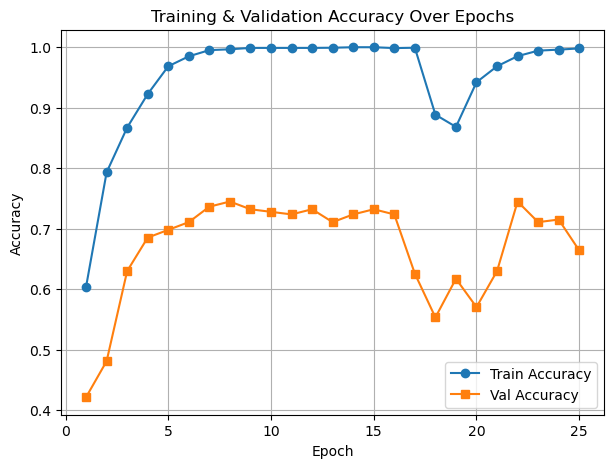

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
from benchmark_ResNet18_multiclass import make_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("data_augmented_multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("data_augmented_multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("data_augmented_multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Compute class weights for oversampling
labels = [label for _, label in train_set]
class_counts = Counter(labels)
num_samples = len(labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Track losses and accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Early stopping variables
early_stop_patience = 10
no_improve_epochs = 0
best_val_loss = float('inf')

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    global no_improve_epochs, best_val_loss
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        scheduler.step()

        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stop_patience:
                print("Early stopping triggered.")
                break

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Test function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Run training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
test_model(model, test_loader)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Since the ResNet pretrained model didn't show a great validation metric I decided to implement the last model which would be a CNN model with a transformer model. it concatenates both outputs and feeds into a shared classifier 

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from Bio import PDB
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split


# One-hot encoding map for 20 amino acids
AA_CODES = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]
AA_TO_INDEX = {aa: idx for idx, aa in enumerate(AA_CODES)}

# Function to extract amino acid sequence from PDB file
def extract_sequence_from_pdb(pdb_path):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    sequence = []
    for model in structure:
        for chain in model:
            for residue in chain:
                resname = residue.get_resname()
                if resname in AA_TO_INDEX:
                    sequence.append(resname)
    return sequence

# One-hot encoding function
def one_hot_encode_sequence(sequence):
    onehot = np.zeros((len(sequence), len(AA_CODES)), dtype=int)
    for i, aa in enumerate(sequence):
        if aa in AA_TO_INDEX:
            onehot[i, AA_TO_INDEX[aa]] = 1
    return onehot

# Custom Dataset combining image paths and one-hot CSV paths
class HybridProteinDataset(Dataset):
    def __init__(self, image_paths, onehot_paths, labels, transform=None):
        self.image_paths = image_paths
        self.onehot_paths = onehot_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = plt.imread(self.image_paths[idx])[:,:,:3]  # ensure RGB
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image).permute(2, 0, 1).float()

        onehot = pd.read_csv(self.onehot_paths[idx]).values.astype(np.float32)
        onehot_tensor = torch.tensor(onehot)

        label = self.labels[idx]
        return image, onehot_tensor, label

# CNN for image processing
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x.view(x.size(0), -1)  # flatten

# Transformer for one-hot sequence
class SequenceTransformer(nn.Module):
    def __init__(self, input_dim=20, emb_dim=64, nhead=4, hidden_dim=128, nlayers=2):
        super(SequenceTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, emb_dim]
        x = x.permute(1, 0, 2)  # [seq_len, batch, emb_dim]
        x = self.transformer(x)  # [seq_len, batch, emb_dim]
        x = x.permute(1, 2, 0)  # [batch, emb_dim, seq_len]
        x = self.pool(x).squeeze(2)  # [batch, emb_dim]
        return x

# Combined model
class CNNTransformerNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNTransformerNet, self).__init__()
        self.cnn = CNNBackbone()
        self.transformer = SequenceTransformer()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, img, seq):
        img_feat = self.cnn(img)
        seq_feat = self.transformer(seq)
        combined = torch.cat((img_feat, seq_feat), dim=1)
        return self.classifier(combined)

# Load data
base_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
classes = ["protein_antigens_non-immunogenic", "protein_antigens_immunogenic", "bacterial_non_antigens", "bacterial_antigens"]
image_paths, onehot_paths, labels = [], [], []
matched = 0
missing_csv_list = []

for class_index, class_name in enumerate(classes):
    img_dir = os.path.join(base_dir, class_name, "voronoi_images")
    onehot_dir = os.path.join(base_dir, class_name, "onehot_sequences")

    for img_path in glob.glob(os.path.join(img_dir, "*.png")):
        base = os.path.basename(img_path)

        # Determine clean name
        clean_name = base.replace(".pdb.png", "").replace(".png", "")
        if clean_name.startswith("AF_REMOTE_AF-"):
            clean_name = clean_name.replace("AF_REMOTE_", "")

        onehot_name = None
        if os.path.exists(os.path.join(onehot_dir, f"{clean_name}_onehot.csv")):
            onehot_name = f"{clean_name}_onehot.csv"
        elif os.path.exists(os.path.join(onehot_dir, f"{clean_name}.csv")):
            onehot_name = f"{clean_name}.csv"
        elif os.path.exists(os.path.join(onehot_dir, f"{base}.csv")):
            onehot_name = f"{base}.csv"

        if onehot_name:
            onehot_path = os.path.join(onehot_dir, onehot_name)
            print(f"Checking: {onehot_path} for image {img_path}")
            image_paths.append(img_path)
            onehot_paths.append(onehot_path)
            labels.append(class_index)
            matched += 1
        else:
            print(f"Missing CSV for: {clean_name}")
            missing_csv_list.append(clean_name)

with open("missing_csv_log.txt", "w") as f:
    for name in missing_csv_list:
        f.write(name + "\n")

print(f"Total matched pairs: {matched}")

if len(image_paths) == 0:
    raise ValueError("No matched image and embedded sequence files found across classes. Check that 'onehot_sequences' contains matching CSV files and that the image filenames are properly formatted.")

train_img, test_img, train_onehot, test_onehot, train_labels, test_labels = train_test_split(
    image_paths, onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_img, val_img, train_onehot, val_onehot, train_labels, val_labels = train_test_split(
    train_img, train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42
)


Checking: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens_non-immunogenic/onehot_sequences/AF-A6PW57-F1_onehot.csv for image /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens_non-immunogenic/voronoi_images/AF-A6PW57-F1.pdb.png
Checking: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens_non-immunogenic/onehot_sequences/AF-M0R211-F1_onehot.csv for image /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens_non-immunogenic/voronoi_images/AF-M0R211-F1.pdb.png
Checking: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens_non-immunogenic/onehot_sequences/AF-F5GY35-F1_onehot.csv for image /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/protein_antigens

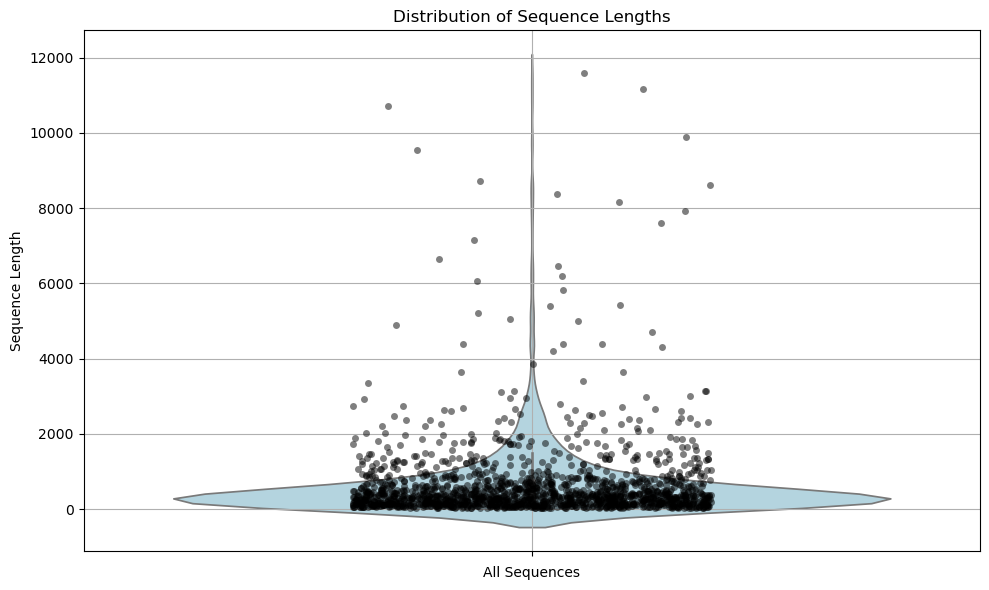

In [5]:
import seaborn as sns

# === Violin plot of sequence lengths with individual dots ===
sequence_lengths = []

for path in onehot_paths:
    try:
        df = pd.read_csv(path)
        sequence_lengths.append(len(df))
    except Exception as e:
        print(f"Error reading {path}: {e}")

# Create the violin plot with overlaid dots
plt.figure(figsize=(10, 6))
sns.violinplot(data=sequence_lengths, inner="box", color="lightblue")
sns.stripplot(data=sequence_lengths, color="black", jitter=0.2, alpha=0.5)

plt.title("Distribution of Sequence Lengths")
plt.xlabel("All Sequences")
plt.ylabel("Sequence Length")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# === cnn_transformer_split.py ===


import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

csv_dirs = glob.glob("/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/*/onehot_sequences/*.csv")

# === Constants ===
AA_CODES = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
            "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
AA_TO_INDEX = {aa: idx for idx, aa in enumerate(AA_CODES)}
NUM_FEATURES = len(AA_CODES)
MAX_SEQ_LENGTH = 4000
#for path in csv_dirs:
    #try:
        #df = pd.read_csv(path)
        #if df.shape[1] == NUM_FEATURES:
            #MAX_SEQ_LENGTH = max(MAX_SEQ_LENGTH, len(df))
    #except Exception:
        #continue
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === Dataset Classes ===
class ImageOnlyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image) if self.transform else TF.to_tensor(TF.resize(image, (224, 224)))
        return image, self.labels[idx]

class SequenceOnlyDataset(Dataset):
    def __init__(self, seq_paths, labels):
        self.seq_paths = seq_paths
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        onehot = pd.read_csv(self.seq_paths[idx]).values.astype(np.float32)
        if onehot.shape[1] != NUM_FEATURES:
            raise ValueError("Incorrect one-hot format")
        onehot = onehot[:MAX_SEQ_LENGTH]
        if len(onehot) < MAX_SEQ_LENGTH:
            pad_len = MAX_SEQ_LENGTH - len(onehot)
            onehot = np.vstack([onehot, np.zeros((pad_len, NUM_FEATURES))])
        return torch.tensor(onehot, dtype=torch.float32), self.labels[idx]



class HybridProteinDataset(Dataset):
    def __init__(self, image_paths, onehot_paths, labels, transform=None):
        self.image_paths = image_paths
        self.onehot_paths = onehot_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image) if self.transform else TF.to_tensor(TF.resize(image, (224, 224)))
        onehot = pd.read_csv(self.onehot_paths[idx]).values.astype(np.float32)
        if onehot.shape[1] != NUM_FEATURES:
            raise ValueError("Bad one-hot shape")
        onehot = onehot[:MAX_SEQ_LENGTH]
        if len(onehot) < MAX_SEQ_LENGTH:
            pad_len = MAX_SEQ_LENGTH - len(onehot)
            onehot = np.vstack([onehot, np.zeros((pad_len, NUM_FEATURES))])
        return image, torch.tensor(onehot), self.labels[idx]

# === Models ===
class CNNBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x.view(x.size(0), -1)

class SequenceTransformer(nn.Module):
    def __init__(self, input_dim=20, emb_dim=64, nhead=4, hidden_dim=128, nlayers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.permute(0, 2, 1)
        return self.pool(x).squeeze(2)

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = CNNBackbone()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256), 
            nn.ReLU(), nn.Dropout(0.4), 
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.cnn(x))

class SequenceClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.transformer = SequenceTransformer()
        self.classifier = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.transformer(x))

class CNNTransformerNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = CNNBackbone()
        self.transformer = SequenceTransformer()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28 + 64, 256),
            nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, img, seq):
        img_feat = self.cnn(img)
        seq_feat = self.transformer(seq)
        return self.classifier(torch.cat((img_feat, seq_feat), dim=1))

# === Training Function ===
def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=1e-4, device='cpu', model_name="Model"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    print(f"\n--- Starting training for {model_name} ---")
    for epoch in range(num_epochs):
        model.train()
        correct, total, total_loss = 0, 0, 0.0
        for batch in train_loader:
            if len(batch) == 3:  # Hybrid dataset
                img, seq, y = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                outputs = model(img, seq)
            else:  # Single input
                x, y = batch[0].to(device), batch[1].to(device)
                outputs = model(x)

            optimizer.zero_grad()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_accs.append(correct / total)
        train_losses.append(total_loss / len(train_loader))

        if val_loader:
            model.eval()
            correct, total, total_loss = 0, 0, 0.0
            with torch.no_grad():
                for batch in val_loader:
                    if len(batch) == 3:  # Hybrid dataset
                        img, seq, y = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                        outputs = model(img, seq)
                    else:
                        x, y = batch[0].to(device), batch[1].to(device)
                        outputs = model(x)

                    loss = criterion(outputs, y)
                    total_loss += loss.item()
                    correct += (outputs.argmax(1) == y).sum().item()
                    total += y.size(0)

            val_accs.append(correct / total)
            val_losses.append(total_loss / len(val_loader))
            print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
        else:
            print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.4f} | Train Loss: {train_losses[-1]:.4f}")

    return model, train_accs, val_accs, train_losses, val_losses

# === Evaluation ===
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            preds = model(x).argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return np.array(all_labels), np.array(all_preds)

# === Utility: Data loading ===
def load_image_sequence_paths(base_dir, classes):
    image_paths, onehot_paths, labels = [], [], []
    for class_idx, class_name in enumerate(classes):
        img_dir = os.path.join(base_dir, class_name, "voronoi_images")
        csv_dir = os.path.join(base_dir, class_name, "onehot_sequences")
        for img_path in glob.glob(os.path.join(img_dir, "*.png")):
            base = os.path.basename(img_path).replace(".pdb.png", "").replace(".png", "")
            base = base.replace("AF_REMOTE_", "") if base.startswith("AF_REMOTE_AF-") else base
            for suffix in ["_onehot.csv", ".csv"]:
                onehot_path = os.path.join(csv_dir, base + suffix)
                if os.path.exists(onehot_path):
                    image_paths.append(img_path)
                    onehot_paths.append(onehot_path)
                    labels.append(class_idx)
                    break
    return image_paths, onehot_paths, labels



===== Training CNN Backbone =====

--- Starting training for CNN ---
[CNN] Epoch 1/10 | Train Acc: 0.3822 | Val Acc: 0.3548 | Train Loss: 2.9381 | Val Loss: 1.4775
[CNN] Epoch 2/10 | Train Acc: 0.6007 | Val Acc: 0.4839 | Train Loss: 0.9743 | Val Loss: 1.1016
[CNN] Epoch 3/10 | Train Acc: 0.7158 | Val Acc: 0.6210 | Train Loss: 0.7529 | Val Loss: 0.8245
[CNN] Epoch 4/10 | Train Acc: 0.7428 | Val Acc: 0.6774 | Train Loss: 0.6526 | Val Loss: 0.7261
[CNN] Epoch 5/10 | Train Acc: 0.7842 | Val Acc: 0.6613 | Train Loss: 0.5246 | Val Loss: 0.6976
[CNN] Epoch 6/10 | Train Acc: 0.7806 | Val Acc: 0.6774 | Train Loss: 0.5018 | Val Loss: 0.6587
[CNN] Epoch 7/10 | Train Acc: 0.8219 | Val Acc: 0.6935 | Train Loss: 0.4379 | Val Loss: 0.6595
[CNN] Epoch 8/10 | Train Acc: 0.8237 | Val Acc: 0.6371 | Train Loss: 0.4166 | Val Loss: 0.6721
[CNN] Epoch 9/10 | Train Acc: 0.8435 | Val Acc: 0.6613 | Train Loss: 0.3919 | Val Loss: 0.6962
[CNN] Epoch 10/10 | Train Acc: 0.8777 | Val Acc: 0.6452 | Train Loss: 0.347

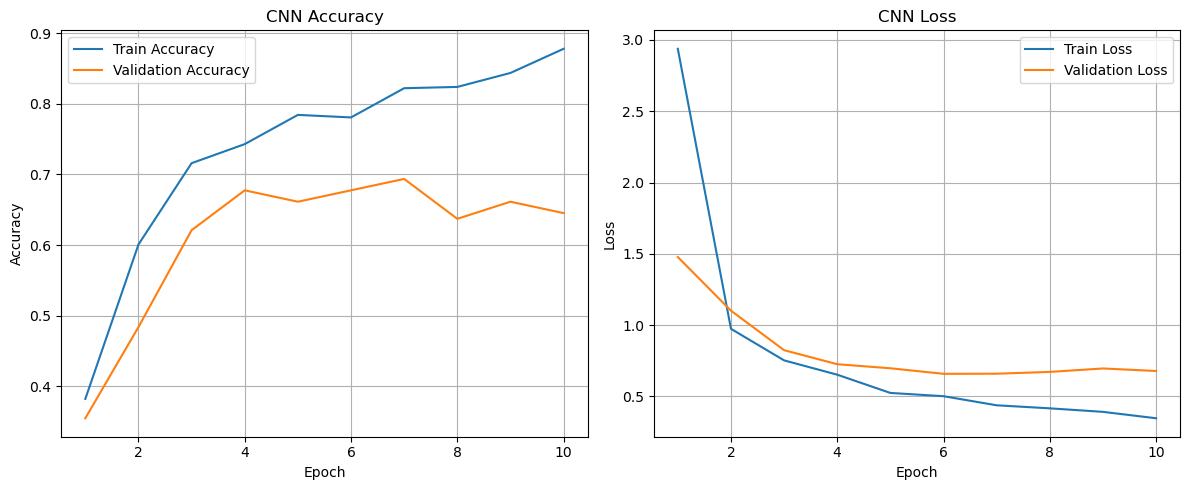

In [3]:
# === cnn_transformer_split_stage1.py ===
# Train the CNN Backbone Only

# (Reuse model and dataset definitions from above)

import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Define plotting function

def plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Model"):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, val_accs, label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_metrics.png")
    plt.show()

# Load data
base_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
classes = ["protein_antigens_non-immunogenic", "protein_antigens_immunogenic", "bacterial_non_antigens", "bacterial_antigens"]
image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)

train_img, test_img, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_img, val_img, train_labels, val_labels = train_test_split(
    train_img, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

image_train_set = ImageOnlyDataset(train_img, train_labels, transform=resize_transform)
image_val_set = ImageOnlyDataset(val_img, val_labels, transform=resize_transform)
image_train_loader = DataLoader(image_train_set, batch_size=32, shuffle=True)
image_val_loader = DataLoader(image_val_set, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNClassifier().to(device)
print("\n===== Training CNN Backbone =====")
cnn_model, train_accs, val_accs, train_losses, val_losses = train_model(cnn_model, image_train_loader, image_val_loader, device=device, model_name="CNN")
print("Final CNN Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="CNN")
torch.save(cnn_model.cnn.state_dict(), "cnn_backbone.pth")



===== Training Transformer Backbone =====

--- Starting training for Transformer ---
[Transformer] Epoch 1/10 | Train Acc: 0.3543 | Val Acc: 0.3629 | Train Loss: 1.3301 | Val Loss: 1.3080
[Transformer] Epoch 2/10 | Train Acc: 0.4191 | Val Acc: 0.3871 | Train Loss: 1.3120 | Val Loss: 1.2969
[Transformer] Epoch 3/10 | Train Acc: 0.4775 | Val Acc: 0.4274 | Train Loss: 1.2767 | Val Loss: 1.2712
[Transformer] Epoch 4/10 | Train Acc: 0.4973 | Val Acc: 0.4274 | Train Loss: 1.2218 | Val Loss: 1.2677
[Transformer] Epoch 5/10 | Train Acc: 0.5027 | Val Acc: 0.4677 | Train Loss: 1.1976 | Val Loss: 1.2686
[Transformer] Epoch 6/10 | Train Acc: 0.5054 | Val Acc: 0.4113 | Train Loss: 1.1734 | Val Loss: 1.2747
[Transformer] Epoch 7/10 | Train Acc: 0.5018 | Val Acc: 0.4677 | Train Loss: 1.1658 | Val Loss: 1.2605
[Transformer] Epoch 8/10 | Train Acc: 0.4991 | Val Acc: 0.4677 | Train Loss: 1.1667 | Val Loss: 1.2726
[Transformer] Epoch 9/10 | Train Acc: 0.5063 | Val Acc: 0.4677 | Train Loss: 1.1416 | Val 

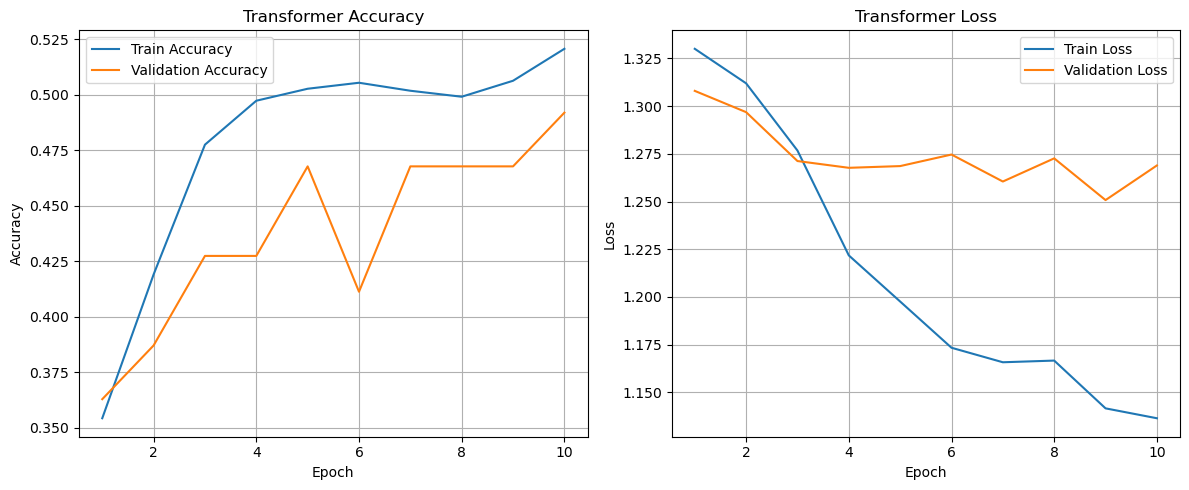

In [ ]:
# === cnn_transformer_split_stage2.py ===
# Train the Transformer Backbone Only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load data again
_, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)
train_onehot, test_onehot, train_labels, test_labels = train_test_split(
    onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_onehot, val_onehot, train_labels, val_labels = train_test_split(
    train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

seq_train_set = SequenceOnlyDataset(train_onehot, train_labels)
seq_val_set = SequenceOnlyDataset(val_onehot, val_labels)
seq_train_loader = DataLoader(seq_train_set, batch_size=16, shuffle=True)
seq_val_loader = DataLoader(seq_val_set, batch_size=16, shuffle=False)

seq_model = SequenceClassifier().to(device)
print("\n===== Training Transformer Backbone =====")
seq_model, train_accs, val_accs, train_lossoses, val_losses = train_model(seq_model, seq_train_loader, seq_val_loader, device=device, model_name="Transformer")
print("Final Transformer Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Transformer")
torch.save(seq_model.transformer.state_dict(), "transformer_backbone.pth")

In [6]:
# === cnn_transformer_split_stage3.py ===
# Combine Both Backbones and Fine-tune Classifier

image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)
train_img, test_img, train_onehot, test_onehot, train_labels, test_labels = train_test_split(
    image_paths, onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_img, val_img, train_onehot, val_onehot, train_labels, val_labels = train_test_split(
    train_img, train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

train_set = HybridProteinDataset(train_img, train_onehot, train_labels, transform=resize_transform)
val_set = HybridProteinDataset(val_img, val_onehot, val_labels, transform=resize_transform)
test_set = HybridProteinDataset(test_img, test_onehot, test_labels, transform=resize_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

model = CNNTransformerNet().to(device)
model.cnn.load_state_dict(torch.load("cnn_backbone.pth"))
model.transformer.load_state_dict(torch.load("transformer_backbone.pth"))

for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.transformer.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

print("\n===== Fine-tuning Combined CNN + Transformer Model =====")
model, train_accs, val_accs, train_losses, val_losses = train_model(model, train_loader, val_loader, device=device, model_name="Combined")
print("Final Combined Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Combined")

def evaluate_combined(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for img, seq, label in loader:
            img, seq = img.to(device), seq.to(device)
            out = model(img, seq)
            preds = out.argmax(1).cpu().numpy()
            y_true.extend(label.numpy())
            y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_combined(model, test_loader)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes)
plt.show()
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))


===== Fine-tuning Combined CNN + Transformer Model =====

--- Starting training for Combined ---


TypeError: CNNTransformerNet.forward() missing 1 required positional argument: 'seq'